For this project I will be building anomaly detection models on a dataset from a collection of Twitter mentions for Apple. 

The data was taken from https://www.kaggle.com/boltzmannbrain/nab

In [2]:
%matplotlib inline

import pandas as pd
from pandas import read_csv
from pandas import datetime

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

from scipy import stats

In [4]:
df = pd.read_csv('Twitter_volume_AAPL.csv')

In [5]:
df.head()

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120


As given from the Kaggle page, the value symbol illustrates the number of mentions the Apple ticker symbol has (AAPL) every five minutes. The goal here is to use anomoly detection to find potential outliers in the dataset. To do that, first I am going to use basic statistical methods.

In [6]:
print(df.dtypes)

timestamp    object
value         int64
dtype: object


The timestamp field is a datetime, so I am going to change that to a datetime object in our dataframe.

In [7]:
df["timestamp"]= pd.to_datetime(df["timestamp"])

In [8]:
df.head()

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120


In [9]:
print(df.dtypes)

timestamp    datetime64[ns]
value                 int64
dtype: object


In descriptive statistics, boxplots are commonly used to determine outliers in a dataset. I will be doing that here below.

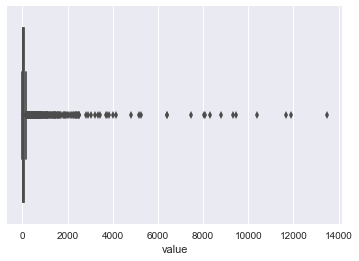

In [11]:
sns.boxplot(x=df['value'])

The box plot shows many potential outiers and a high concentration of points between 0 to 2000. This graph provides good initial feedback on the shape of the data. Next I'm going to plot the data in terms of time to try and visually find any high volume of tweets at any point over the datasets timeline.

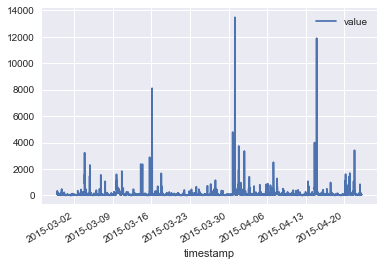

In [19]:
df.plot(x = "timestamp", y = "value")

Based off the graph, there are about 3 major increases in tweet count in the dataset, with many more smaller margin increases. Now that we have a sense of potential outliers in the data, I'm going to use various statistical tools to identify outliers. First I will use the IQR.

In [27]:
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

47.0


Now that I have found the IQR, I will need to establish the cutoff used to determine what is an outlier in this distribution.

Code modified from https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [30]:
cut_off = IQR * 1.5
lower, upper = Q1 - cut_off, Q3 + cut_off

Now that the cutoff has been established for the IQR, we can identify the outliers as the points outside our distribution.

In [41]:
outliers = [x for x in df['value'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Identified outliers: 1250


That's a lot of outliers in this dataset. Another technique we can use to predict anomalies is using a random forest classifier. 

In [50]:
#splitting date into specific features allowing random forest classifier to use as features
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

from sklearn.model_selection import train_test_split
labels = df['value']
features = df[['day', 'month', 'year']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, 
                                                          random_state=42)

In [51]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print (prediction)

#find accuracy score for random forest classifier
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, prediction,))

[50 29 21 ... 33 31 44]
0.015089594467148696


Attempting to use a random forest classifier on this data hasn't proven too succesful witha 1 percent accuracy... it was a good learning experience regardless. I have previously used the random forest regressor for the regression lab in this course. I am curious to see how the results for that compare in the case of this anomaly detection problem. I'd predict it would be equally as poor in prediciting anomalies.

In [52]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
model = rf.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)
print(rf.score(X_test, y_test))

0.03482598439452045


The low score is about as expected. It's not necesarily the best tool for the given problem, but it was an curious questin. Another similair approach we can use for anamoly detection is isolation forest. This approach should yield better results as its better fit for the problem at hand. 

Code adapted from https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [55]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=14)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [57]:
print("Accuracy:",list(y_pred_test).count(1)/y_pred_test.shape[0])

Accuracy: 0.8855705752907891


With an accuracy score of 88.5 percent, this indicates that are data does indeed have anomalies. For background, a score close to 1 indicated anomalies, much less than .5 indicates normal observation, and close to .5 doesn't have clear distinct anomalies.

Given what we found from assessing IQR and using isolation forest, we can see that we have strong indication of anomalies in the data.